# BM25 Evaluation

In [1]:
%load_ext autoreload
%autoreload 2
import json
import sys
import os
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from tqdm.notebook import tqdm
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from evaluation import *
from preprocessing import Corpus, BasicPreprocessing, BigramPreprocessor, SpacyPreprocessor, StopWordPreprocessor
from retrieval_algorithms import BM25RetrievalAlgorithm

#### Load corpus using different preprocessing pipelines

In [32]:
pd.read_csv("../../data/kit_expert_2019_all_papers.csv").shape

(65641, 4)

In [31]:
pd.read_csv("../../data/kit_expert_2019_all_papers_journal_citations.csv").shape

(65641, 4)

In [33]:
base_file =  "../../data/kit_expert_2019_all_papers_journal_citations.csv"

p = [BasicPreprocessing(), StopWordPreprocessor()]
papers_basic = Corpus(base_file, p)

# p = [BasicPreprocessing(), StopWordPreprocessor(), SpacyPreprocessor(lemmatization="all")]
# papers_basic_lemmatization_all = Corpus(base_file, p, load_from_cache=True, n_jobs=16)

# p = [BasicPreprocessing(), StopWordPreprocessor(), SpacyPreprocessor(lemmatization="nouns")]
# papers_basic_lemmatization_nouns = Corpus(base_file, p, load_from_cache=True, n_jobs=16)

INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_NoStopWords" for file ../../data/kit_expert_2019_all_papers_journal_citations.csv.
INFO:preprocessing.pipeline:Start stage "basic"








INFO:preprocessing.pipeline:Finished stage "basic" in 4.04 seconds
INFO:preprocessing.pipeline:Start stage "NoStopWords"







INFO:preprocessing.pipeline:Finished stage "NoStopWords" in 1.59 seconds
INFO:preprocessing.pipeline:Finished preprocessing pipeline. Saved preprocessed corpus to cache file ../../data/kit_expert_2019_all_papers_journal_citations_basic_NoStopWords


#### Load keywords to use as test data

In [34]:
with open("../../data/kit_expert_2019_all_keywords.json", "r") as file:
    keywords = json.load(file)

In [35]:
general_keywords = ("general keywords", [k for k in keywords if k["level"]<=1])
specific_keywords = ("specific_keywords", [k for k in keywords if k["level"]>=2 and len(k["paper_ids"])>=10][:5000])

#### Test simple tf-idf models on unigrams

#### Grid search for BM25 k1 parameter

In [36]:
k1_grid = np.arange(0.1,2.1,0.1)
search_k1_bm25_models = [(f"BM25 k1={k1:.2f}", BM25RetrievalAlgorithm(k1=k1, b=0.5), papers_basic) for k1 in k1_grid]

In [37]:
%%time
search_k1_bm25_results = train_evaluate_models(search_k1_bm25_models, [general_keywords, specific_keywords], n_jobs=len(search_k1_bm25_models))

INFO:root:Start training model BM25 k1=0.50
INFO:root:Start evaluating model BM25 k1=0.50



INFO:root:Finished processing model BM25 k1=0.50
CPU times: user 2min 53s, sys: 24.1 s, total: 3min 17s
Wall time: 3min 16s


In [7]:
print("mAP scores for bm25 k1 search models:")
search_k1_bm25_results

mAP scores for bm25 k1 search models:


general keywords                                    specific_keywords                                   
                          p@5   p@10   p@20 R-prec    mAP  bpref               p@5   p@10   p@20 R-prec    mAP  bpref
BM25 k1=0.10            0.295  0.251  0.216  0.077  0.045  0.061             0.648  0.593  0.499  0.471  0.472  0.457
BM25 k1=0.20            0.296  0.251  0.216  0.078  0.045  0.061             0.650  0.594  0.500  0.472  0.473  0.457
BM25 k1=0.30            0.297  0.250  0.215  0.079  0.046  0.062             0.651  0.594  0.501  0.473  0.473  0.458
BM25 k1=0.40            0.296  0.249  0.216  0.079  0.046  0.062             0.651  0.594  0.501  0.473  0.473  0.458
BM25 k1=0.50            0.295  0.252  0.216  0.082  0.046  0.063             0.652  0.594  0.501  0.473  0.473  0.457
BM25 k1=0.60            0.297  0.252  0.216  0.082  0.047  0.063             0.652  0.595  0.502  0.473  0.472  0.457
BM25 k1=0.70            0.298  0.252  0.216  0.082  0.047  0.064             0.652  0.595  0.501  0.472  0.472  0.456
BM25 k1=0.80            0.299  0.252  0.217  0.082  0.047  0.064             0.652  0.595  0.501  0.471  0.471  0.455
BM25 k1=0.90            0.297  0.252  0.217  0.083  0.047  0.064             0.652  0.594  0.501  0.470  0.469  0.453
BM25 k1=1.00            0.297  0.252  0.217  0.083  0.047  0.064             0.652  0.594  0.500  0.469  0.468  0.451
BM25 k1=1.10            0.297  0.250  0.216  0.083  0.047  0.064             0.652  0.594  0.499  0.467  0.466  0.450
BM25 k1=1.20            0.297  0.251  0.216  0.083  0.047  0.064             0.651  0.594  0.498  0.466  0.464  0.448
BM25 k1=1.30            0.297  0.251  0.216  0.084  0.047  0.065             0.651  0.593  0.497  0.464  0.462  0.445
BM25 k1=1.40            0.297  0.252  0.217  0.084  0.047  0.065             0.650  0.591  0.496  0.462  0.460  0.443
BM25 k1=1.50            0.297  0.252  0.217  0.084  0.047  0.065             0.649  0.590  0.495  0.460  0.458  0.441
BM25 k1=1.60            0.297  0.252  0.217  0.084  0.047  0.065             0.649  0.589  0.493  0.458  0.456  0.438
BM25 k1=1.70            0.299  0.252  0.217  0.085  0.047  0.065             0.648  0.588  0.491  0.456  0.453  0.436
BM25 k1=1.80            0.299  0.252  0.216  0.085  0.047  0.065             0.647  0.586  0.490  0.454  0.451  0.434
BM25 k1=1.90            0.297  0.254  0.216  0.085  0.047  0.065             0.646  0.585  0.489  0.452  0.449  0.432
BM25 k1=2.00            0.297  0.254  0.215  0.085  0.047  0.065             0.645  0.584  0.487  0.450  0.447  0.429

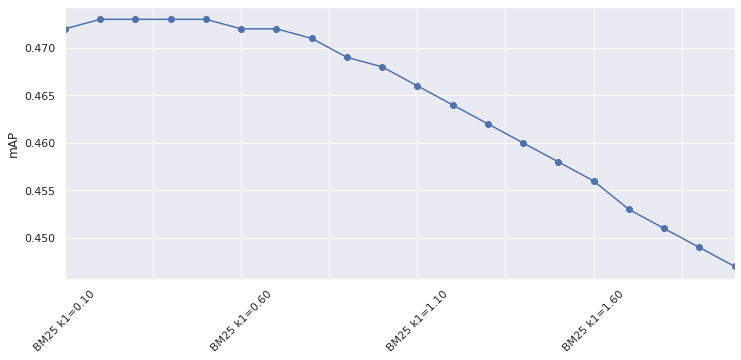

In [8]:
ax = search_k1_bm25_results[("specific_keywords","mAP")].plot(figsize=(12,5), style="-bo", rot=45, legend=False)
ax.set_ylabel("mAP");

Results:
- k1 of 0.2 has the best performance

#### Grid search for BM25 b parameter

In [9]:
b_grid = np.arange(0.1,1.1,0.1)
search_b_bm25_models = [(f"BM25 b={b:.2f}", BM25RetrievalAlgorithm(b=b, k1=0.6), papers_basic) for b in b_grid]

In [ ]:
%%time
search_b_bm25_results = train_evaluate_models(search_b_bm25_models, [general_keywords, specific_keywords], n_jobs=len(search_b_bm25_models))

In [11]:
print("mAP scores for bm25 b search models:")
search_b_bm25_results

mAP scores for bm25 b search models:


general keywords                                    specific_keywords                                   
                         p@5   p@10   p@20 R-prec    mAP  bpref               p@5   p@10   p@20 R-prec    mAP  bpref
BM25 b=0.10            0.291  0.250  0.214  0.080  0.046  0.062             0.637  0.583  0.494  0.467  0.465  0.450
BM25 b=0.20            0.291  0.251  0.214  0.080  0.046  0.062             0.641  0.587  0.496  0.469  0.467  0.452
BM25 b=0.30            0.292  0.252  0.215  0.080  0.046  0.062             0.644  0.590  0.498  0.470  0.469  0.454
BM25 b=0.40            0.293  0.252  0.216  0.080  0.046  0.062             0.648  0.593  0.499  0.472  0.471  0.455
BM25 b=0.50            0.297  0.252  0.216  0.082  0.047  0.063             0.652  0.595  0.502  0.473  0.472  0.457
BM25 b=0.60            0.299  0.253  0.218  0.080  0.046  0.063             0.654  0.596  0.502  0.473  0.474  0.458
BM25 b=0.70            0.301  0.255  0.217  0.080  0.046  0.063             0.654  0.597  0.503  0.474  0.474  0.458
BM25 b=0.80            0.294  0.257  0.215  0.081  0.046  0.063             0.653  0.597  0.502  0.474  0.474  0.458
BM25 b=0.90            0.291  0.254  0.213  0.081  0.046  0.063             0.653  0.596  0.502  0.474  0.474  0.458
BM25 b=1.00            0.291  0.254  0.210  0.080  0.046  0.063             0.652  0.594  0.501  0.474  0.472  0.457

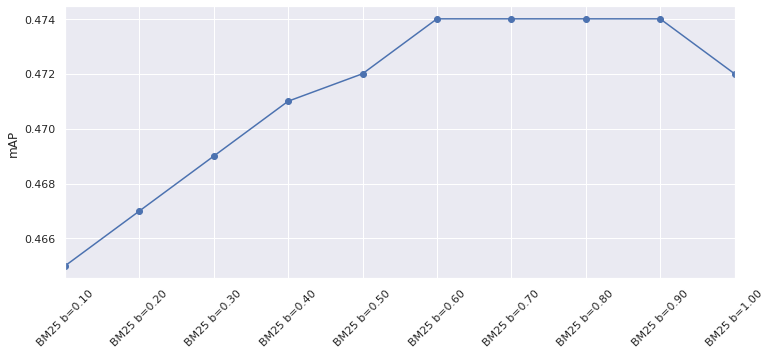

In [12]:
ax = search_b_bm25_results[("specific_keywords","mAP")].plot(figsize=(12,5), style="-bo", rot=45, legend=False)
ax.set_ylabel("mAP");

Results:
- b parameter does not have a great effect on model performance
- best value at 0.7

#### Test bm25 with best parameters on n-grams

In [13]:
ngram_bm25_models = [
    ("bm25 2-gram", BM25RetrievalAlgorithm(max_ngram=2, k1=0.5, b=0.8), papers_basic_lemmatization_nouns),
    ("bm25 3-gram", BM25RetrievalAlgorithm(max_ngram=3, k1=0.5, b=0.8), papers_basic_lemmatization_nouns),
    ("bm25 4-gram", BM25RetrievalAlgorithm(max_ngram=4, k1=0.5, b=0.8), papers_basic_lemmatization_nouns),
]

In [14]:
ngram_bm25_results = train_evaluate_models(ngram_bm25_models, [general_keywords, specific_keywords])

INFO:root:Start training model bm25 2-gram
INFO:root:Start training model bm25 3-gram
INFO:root:Start training model bm25 4-gram
INFO:root:Start evaluating model bm25 2-gram


INFO:root:Start evaluating model bm25 3-gram


INFO:root:Start evaluating model bm25 4-gram



INFO:root:Finished processing model bm25 2-gram

INFO:root:Finished processing model bm25 3-gram

INFO:root:Finished processing model bm25 4-gram


In [15]:
print("mAP scores for ngram bm25 models:")
ngram_bm25_results

mAP scores for ngram bm25 models:


general keywords                                    specific_keywords                                   
                         p@5   p@10   p@20 R-prec    mAP  bpref               p@5   p@10   p@20 R-prec    mAP  bpref
bm25 2-gram            0.308  0.261  0.217  0.085  0.049  0.066             0.732  0.674  0.567  0.549  0.559  0.545
bm25 3-gram            0.308  0.258  0.216  0.084  0.049  0.066             0.733  0.673  0.566  0.549  0.558  0.545
bm25 4-gram            0.307  0.258  0.217  0.085  0.049  0.066             0.733  0.672  0.565  0.548  0.557  0.544

Results:
- bigrams improve result of bm25
- bm25 bigram model achieves best score on specific keywords
- general keyword score still very low

In [ ]:
from query_expansion_retrieval import QueryExpansionRetrieval

In [ ]:
with open("../data/keyword_hierarchy.json", 'r') as file:
    keyword_hierarchy = json.load(file)

In [ ]:
bm25_model_unigram = TfidfRetrieval(corpus=papers_basic, max_ngram=1, use_bm25=True, k1=0.9, b=0.7)
bm25_model_bigram = TfidfRetrieval(corpus=papers_basic, max_ngram=2, use_bm25=True, k1=0.9, b=0.7)

In [ ]:
query_expansion_models = [
    ("qe unigram expand all", 
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=False,
             separate_weighting=False)),
    ("qe unigram expand first",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=False)),
    ("qe bigram expand all", 
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_bigram,
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=False,
             separate_weighting=False)),
    ("qe bigram expand first",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_bigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=False)),
    ("qe unigram expand all separate weighting",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=False,
             separate_weighting=True)),
    ("qe unigram expand first separate weighting",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=True))
]

In [ ]:
query_expansion_results = train_evaluate_models(query_expansion_models, [general_keywords, specific_keywords])

In [46]:
print("mAP scores for query expansion models:")
query_expansion_results

mAP scores for query expansion models:


,general keywords,specific_keywords
qe unigram expand all,0.130445,0.353119
qe unigram expand first,0.132192,0.357417
qe bigram expand all,0.146867,0.484990
qe bigram expand first,0.135623,0.490216
qe unigram expand all separate weighting,0.115465,0.394972
qe unigram expand first separate weighting,0.109443,0.395540


In [ ]:
bm25_model_unigram = TfidfRetrieval(corpus=papers_basic_lemmatization_nouns, max_ngram=1, use_bm25=True, k1=0.9, b=0.8)
bm25_model_bigram = TfidfRetrieval(corpus=papers_basic_lemmatization_nouns, max_ngram=2, use_bm25=True, k1=0.9, b=0.8)

In [ ]:
query_expansion_models_lem = [
    ("qe unigram expand first",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=False)),
    ("qe bigram expand first",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_bigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=False)),
    ("qe unigram expand first separate weighting",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=True))
]

In [ ]:
query_expansion_results_lem = train_evaluate_models(query_expansion_models_lem, [general_keywords, specific_keywords])

In [47]:
print("mAP scores for query expansion models with lemmatization:")
query_expansion_results_lem

mAP scores for query expansion models with lemmatization:


,general keywords,specific_keywords
qe unigram expand first,0.136965,0.362818
qe bigram expand first,0.138769,0.510962
qe unigram expand first separate weighting,0.112999,0.379990


In [17]:
best_bm25_model = BM25RetrievalAlgorithm(max_ngram=2, k1=0.6, b=0.7)
best_bm25_model.prepare(papers_basic_lemmatization_nouns)

In [18]:
def check_correct(model, keywords, query):
    keyword = [k for k in keywords if k["keyword"]==query][0]
    print(len(keyword["paper_ids"]))
    result = model.get_ranking(query)
    result["correct"] = result["id"].isin(keyword["paper_ids"])
    return result

In [89]:
[k for k in keywords if k["keyword"]=="bellman equation"][0]

{'keyword': 'bellman equation',
 'paper_ids': ['11432240',
  '1523005464',
  '1973133746',
  '1982556518',
  '2008839174',
  '2012940290',
  '2013786427',
  '2015692920',
  '2020339859',
  '2024680294',
  '2037007317',
  '2071920504',
  '2076764011',
  '2085875325',
  '2146188858',
  '2148527622',
  '2172280408',
  '2257227894',
  '2292288584',
  '2341059095',
  '2508812448',
  '2885898206',
  '2963011725',
  '2963160574',
  '2972364126',
  '2991199092',
  '307202153',
  '51454524',
  '77657119',
  '86068839'],
 'level': 2,
 'keyword_id': '14646407',
 'child_ids': [196978813, 60810621, 79911916]}

In [63]:
r = calculate_metrics(best_bm25_model,specific_keywords[1][:1000], default_metrics)

In [65]:
r.sort_values(by="mAP").head(20)

,query,p@5,p@10,p@20,R-prec,mAP,bpref
406,INT,0.0,0.0,0.00,0.000000,0.000000,0.000000
87,Chemometrics,0.0,0.0,0.00,0.000000,0.000000,0.000000
105,Igneous petrology,0.0,0.0,0.00,0.000000,0.000000,0.000000
580,Coining (mint),0.0,0.0,0.00,0.000000,0.000000,0.000000
230,Cellular biophysics,0.0,0.0,0.00,0.000000,0.000000,0.000000
83,Cryosphere,0.0,0.0,0.00,0.000000,0.000000,0.000000
309,Photoelectrochemistry,0.0,0.0,0.00,0.000000,0.000000,0.000000
553,Salience (neuroscience),0.0,0.0,0.00,0.000000,0.000000,0.000000
438,Biomimetics,0.0,0.0,0.00,0.000000,0.000000,0.000000
210,Pound (mass),0.0,0.0,0.00,0.000000,0.000000,0.000000


In [22]:
check_correct(best_bm25_model, keywords, "Computer science").head(20)

9250


,id,score,correct
19221,2002763011,20.471458,True
65005,2292280670,20.354965,True
44781,2460467776,18.944059,False
30179,2931200840,18.912713,True
12836,1531010687,18.733358,True
19220,2113294746,18.474499,True
22918,1982531395,18.375133,True
831,2065480817,18.284965,True
794,1971571711,17.599239,False
19305,1971251577,17.438381,True


In [ ]:
r[r["query"]==""]